<a href="https://colab.research.google.com/github/DonaldGubin/MLandDL/blob/main/homework_pytorch_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# implementation and training of logistic regression in pythorch


In [1]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

## creating dataset

In [2]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

y = 2 * y - 1 # Make classes (0, 1) into classes +- 1

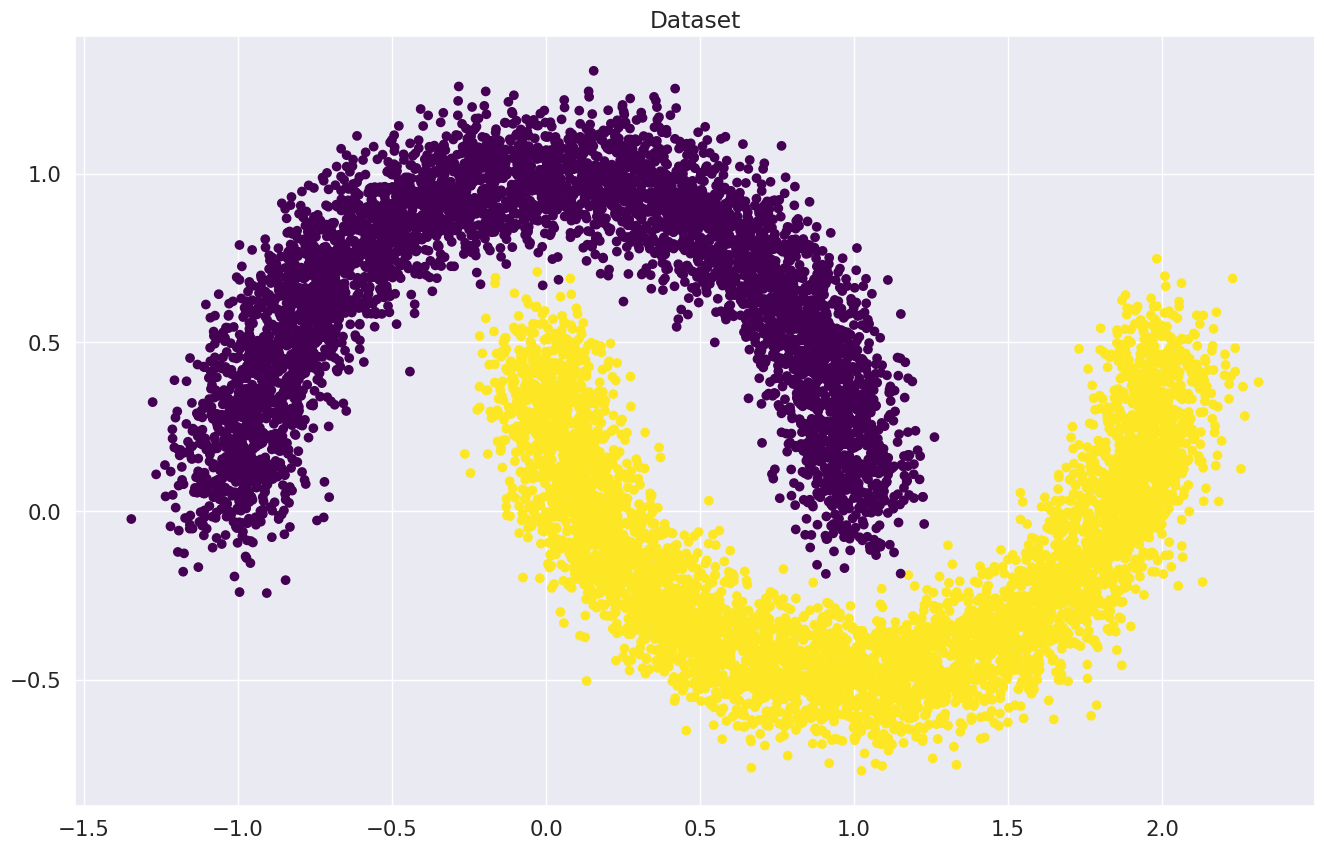

In [3]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

In [5]:
X_train_t =  torch.tensor(X_train, dtype = torch.float64)
y_train_t =  torch.tensor(y_train, dtype = torch.float64)
X_val_t =  torch.tensor(X_val, dtype = torch.float64)
y_val_t =  torch.tensor(y_val, dtype = torch.float64)

In [6]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

### Creating Logistic Regression Module


In [7]:
class LogisticRegression(nn.Module):
    def __init__(self, n: int):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(n, 1).type(torch.float64), requires_grad=True)

    def forward(self, x): #x has shape (l, n)
        result =  x @ self.weights
        return result

In [8]:
test_model = LogisticRegression(n=2)

### Calculation of the loss function

In [9]:
X_batch = torch.DoubleTensor([[2., 0.5], [0.3, -4.5], [8.2, 0.4]])
w = torch.DoubleTensor([3.6, -2.2]).view(2, 1)
y_batch = torch.tensor([1, -1, 1])
X_batch, w, y_batch

(tensor([[ 2.0000,  0.5000],
         [ 0.3000, -4.5000],
         [ 8.2000,  0.4000]], dtype=torch.float64),
 tensor([[ 3.6000],
         [-2.2000]], dtype=torch.float64),
 tensor([ 1, -1,  1]))

In [10]:
test_model.weights = nn.Parameter(w, requires_grad=True)

outp =  X_batch @ test_model.weights

outp = outp.flatten()

outp1 = -y_batch * outp

all_losses =  torch.log(1 + torch.exp(outp1))

loss = torch.mean(all_losses)

In [11]:
assert torch.allclose(loss, torch.DoubleTensor([3.66]), rtol=1e-3), 'Wrong'

### Realization of the learning cycle

In [12]:
logistic_regression = LogisticRegression(n=2)
optimizer = torch.optim.SGD(logistic_regression.parameters(), lr=0.05)

In [13]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(logistic_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()


        outp = logistic_regression(X_batch)

        outp = outp.flatten()

        loss =  torch.mean(torch.log(1 + torch.exp(-y_batch * outp)))

        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()


        probabilities = torch.sigmoid(outp)


        preds = (probabilities > 0.5).type(torch.long)
        preds = preds * 2 - 1

        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)

        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = logistic_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.1875
Iteration: 100
Batch accuracy: 0.6953125
Iteration: 200
Batch accuracy: 0.8046875
Iteration: 300
Batch accuracy: 0.875
Iteration: 400
Batch accuracy: 0.8515625
Iteration: 500
Batch accuracy: 0.875
Iteration: 600
Batch accuracy: 0.859375
Iteration: 700
Batch accuracy: 0.828125
Iteration: 800
Batch accuracy: 0.84375

Iteration: 818.Convergence. Stopping iterations.


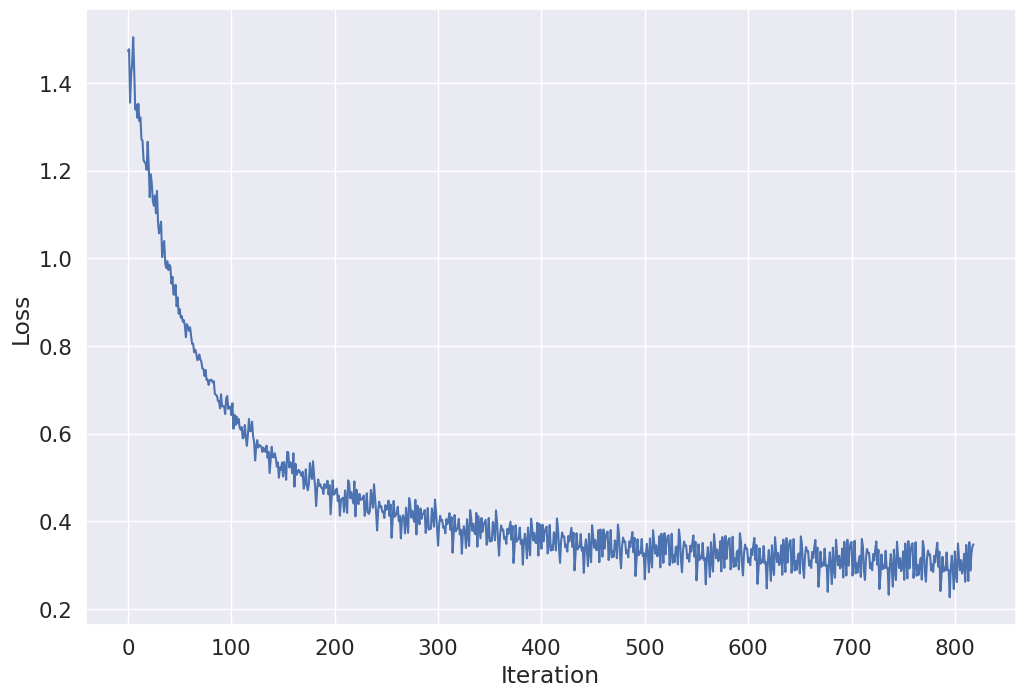

In [14]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

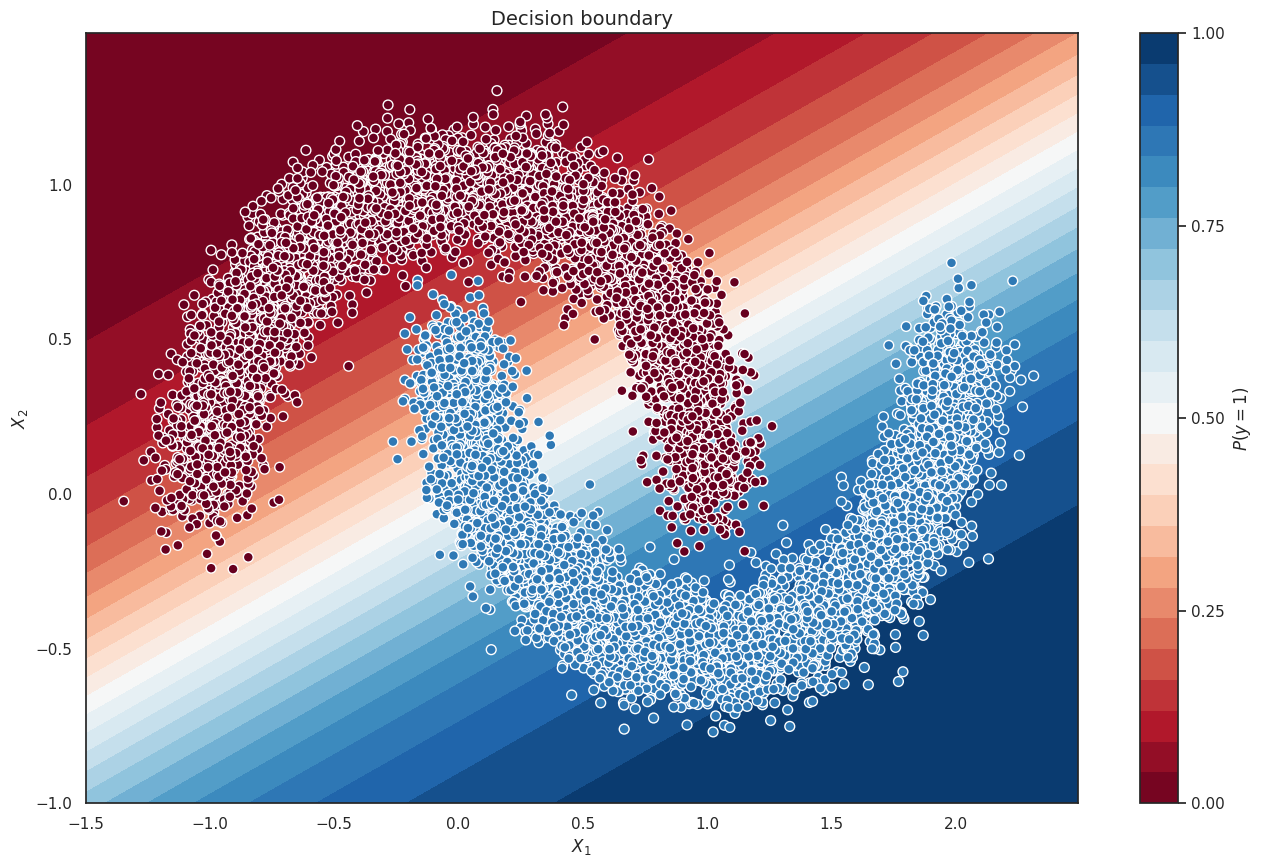

In [15]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float64)
with torch.no_grad():
    probs = torch.sigmoid(logistic_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

In [16]:
from sklearn.linear_model import LogisticRegression as lr
from sklearn.metrics import accuracy_score

model = lr(C=10000).fit(X_train, y_train)
accuracy_score(y_val, model.predict(X_val))


0.8916

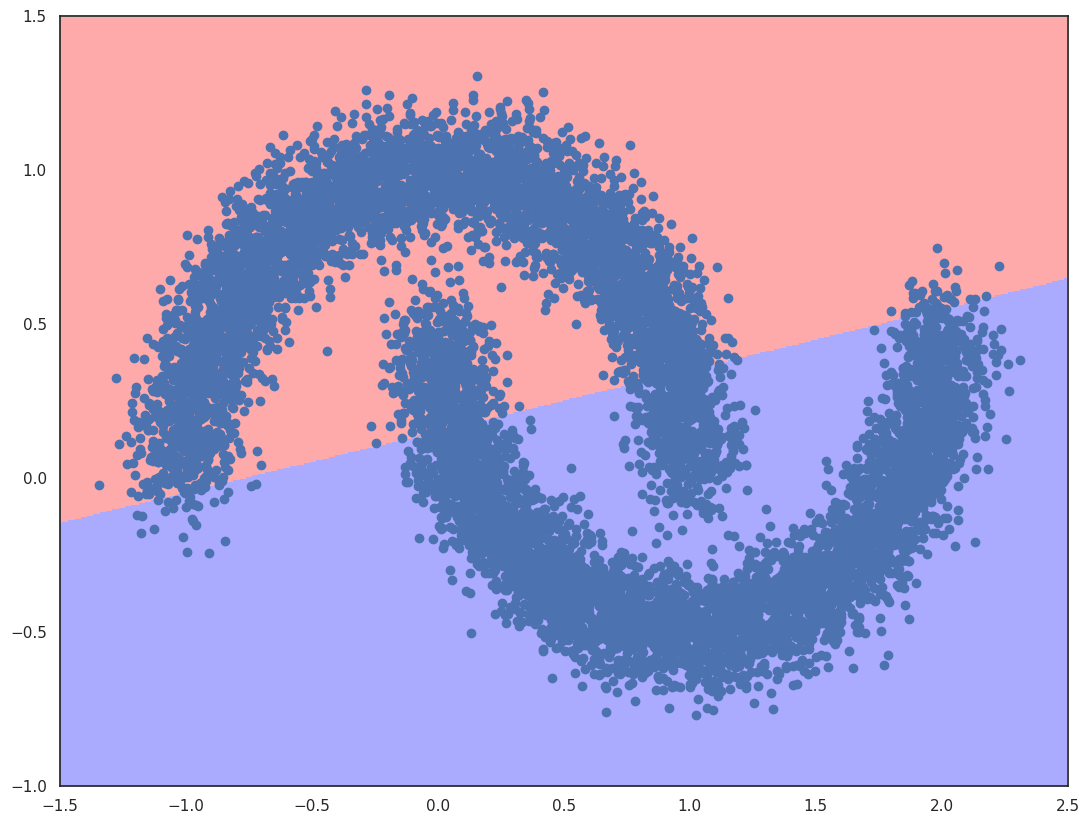

In [17]:
from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])

plt.figure(figsize=(13,10))

x_min = -1.5
x_max = 2.5
y_min = -1.
y_max = 1.5
h = 0.005

plt.xlim((x_min, x_max))
plt.ylim((y_min, y_max))
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h))

Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)

plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

plt.scatter(X[:, 0], X[:, 1],)
plt.show()

In [18]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()

    outp = logistic_regression(X_val_t).flatten()

    probabilities = torch.sigmoid(outp)


    preds = (probabilities > 0.5).type(torch.long)

    preds = preds * 2 - 1

    return preds

In [19]:
from sklearn.metrics import accuracy_score

preds = predict(val_dataset, logistic_regression)

accuracy = accuracy_score(y_val_t, preds)

print(f"Overall accuracy: {accuracy:.4f}")

Overall accuracy: 0.8664
